In [33]:
import matplotlib.pyplot as plt
from matplotlib import ticker as mticker
from matplotlib import patches as mpatches
import logging

In [34]:
logger = logging.getLogger()
logging.basicConfig(level=logging.INFO)

In [2]:
%matplotlib inline
# plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 120
# plt.rcParams['axes.spines.right'] = False

In [3]:
import pandas as pd
import numpy as np

In [4]:
items = [
    {"type": "drilled_hole", "from": 0, "to": 12, "diam": 438, "drilling_order": 0, "label": ""},
    {"type": "drilled_hole", "from": 186, "to": 998.8, "diam": 222, "drilling_order": 2, "label": "main hole"},
    {"type": "drilled_hole", "from": 12, "to": 186, "diam": 311, "drilling_order": 1},
    {"type": "cement_plug", "from": 867, "to": 998.8, "drilling_order": 3},
    {"type": "drilled_hole", "from": 867, "to": 1100, "diam": 149, "drilling_order": 4 },
    {"type": "casing", "from": 0, "to": 12, "inner_diam": 326, "label": "conductor"},
    {"type": "cemented_annulus", "from": 0, "to": 12, "inner_annulus_diam": 326},
    {"type": "casing", "from": 0, "to": 996.5, "inner_diam": 162, "label": "7\" API casing"},
    {"type": "cemented_annulus", "from": 53, "to": 996.5, "inner_annulus_diam": 162},
    {"type": "casing", "from": 0, "to": 184, "inner_diam": 227, "label": "artesian control"},
    {"type": "cemented_annulus", "from": 0, "to": 184, "inner_annulus_diam": 227},
    {"type": "casing", "from": 0, "to": 320, "inner_diam": 104, "label": "fictional reline"},
    {"type": "cemented_annulus", "from": 0, "to": 50, "inner_annulus_diam": 104},
]

__version__ = 'dev'

pd.DataFrame(items).fillna("")

,type,from,to,diam,drilling_order,label,inner_diam,inner_annulus_diam
0,drilled_hole,0,12.0,438.0,0.0,,,
1,drilled_hole,186,998.8,222.0,2.0,main hole,,
2,drilled_hole,12,186.0,311.0,1.0,,,
3,cement_plug,867,998.8,,3.0,,,
4,drilled_hole,867,1100.0,149.0,4.0,,,
5,casing,0,12.0,,,conductor,326.0,
6,cemented_annulus,0,12.0,,,,,326.0
7,casing,0,996.5,,,"7"" API casing",162.0,
8,cemented_annulus,53,996.5,,,,,162.0
9,casing,0,184.0,,,artesian control,227.0,


In [15]:
def parse_items(items, schema_type="drilled_hole_casing"):
    if schema_type == "drilled_hole_casing":
        return parse_items_for_drilled_hole_casing_schema(items)
    else:
        raise KeyError(
            f"schema_type {schema_type} is not recognised by well_schematics v{__version__}"
        )


def parse_items_for_drilled_hole_casing_schema(items):
    sorted_items = {}
    
    drilling_items = [x for x in items if x['type'] in ('drilled_hole', 'cement_plug')]
    dh_idxs = [x for x in range(len(drilling_items))]
    dh_order_diams = sorted(dh_idxs, key=lambda x: drilling_items[x].get('diam', 9999))
    sorted_items['drilling'] = [dict(i=i, order_diam=dh_order_diams.index(i), **drilling_items[i]) for i in dh_idxs]
    
    cs_items = [x for x in items if x['type'] == 'casing']
    cs_idxs = [x for x in range(len(cs_items))]
    cs_order_diams = sorted(cs_idxs, key=lambda x: cs_items[x]['inner_diam'])
    sorted_items['casing'] = [dict(i=i, order_diam=cs_order_diams.index(i), **cs_items[i]) for i in cs_idxs]
    
    return sorted_items
    


def parsed_items_to_dataframe(sitems):
    keys = [
        "type",
        "i",
        "order_diam",
        "drilling_order",
        "from",
        "to",
        "diam",
        "inner_diam",
        "label",
    ]
    df = pd.concat([pd.DataFrame(t) for t in sitems.values()])
    for key in keys:
        if not key in df:
            df[key] = None
    return df[keys]

In [16]:
def get_intervals(df):
    depths = sorted(set(list(df["from"].unique()) + list(df["to"].unique())))
    return [(depths[i], depths[i + 1]) for i in range(len(depths) - 1)]

def subset_construction_by_intervals(df):
    intervals = get_intervals(df)
    for interval in intervals:
        subset = df[(df['from'] < interval[1]) & (df['to'] > interval[0])]
        yield interval, subset

In [18]:
sorted_items = parse_items(items)
df = parsed_items_to_dataframe(sorted_items)
df.sort_values(['from', 'to'])

,type,i,order_diam,drilling_order,from,to,diam,inner_diam,label
0,drilled_hole,0,3,0.0,0,12.0,438.0,NaN,
0,casing,0,3,NaN,0,12.0,NaN,326.0,conductor
2,casing,2,2,NaN,0,184.0,NaN,227.0,artesian control
3,casing,3,0,NaN,0,320.0,NaN,104.0,fictional reline
1,casing,1,1,NaN,0,996.5,NaN,162.0,"7"" API casing"
2,drilled_hole,2,2,1.0,12,186.0,311.0,NaN,NaN
1,drilled_hole,1,1,2.0,186,998.8,222.0,NaN,main hole
3,cement_plug,3,4,3.0,867,998.8,NaN,NaN,NaN
4,drilled_hole,4,0,4.0,867,1100.0,149.0,NaN,NaN


In [27]:
def parse(items):
    if isinstance(items, pd.DataFrame):
        items = items.to_dict(orient="records")
    parsed_items = parse_items(items)
    return parsed_items_to_dataframe(parsed_items)
    

In [30]:
df = parse(pd.DataFrame([
    {"type": "drilled_hole", "drilling_order": 0, "from": 0, "to": 100, "diam": 200},
    {"type": "drilled_hole", "drilling_order": 2, "from": 0, "to": 100, "diam": 100},
    {"type": "cement_plug", "drilling_order": 1, "from": 50, "to": 60},
]))
with pd.option_context("display.width", 1000):
    print(df)

           type  i  order_diam  drilling_order  from   to   diam inner_diam label
0  drilled_hole  0           1               0     0  100  200.0       None  None
1  drilled_hole  1           0               2     0  100  100.0       None  None
2   cement_plug  2           2               1    50   60    NaN       None  None


INFO:root:Depth interval: (0, 50)
INFO:root:Drilled hole sections in interval, ordered by diameter:
           type  i  order_diam  drilling_order  from   to   diam inner_diam label
1  drilled_hole  1           0               2     0  100  100.0       None  None
0  drilled_hole  0           1               0     0  100  200.0       None  None
INFO:root:For drillhole 1, later_max_dhole_diam=nan
INFO:root:For drillhole 0, later_max_dhole_diam=100.0
INFO:root:Depth interval: (50, 60)
INFO:root:Drilled hole sections in interval, ordered by diameter:
           type  i  order_diam  drilling_order  from   to   diam inner_diam label
1  drilled_hole  1           0               2     0  100  100.0       None  None
0  drilled_hole  0           1               0     0  100  200.0       None  None
INFO:root:For drillhole 1, later_max_dhole_diam=nan
INFO:root:For drillhole 0, later_max_dhole_diam=100.0
INFO:root:Depth interval: (60, 100)
INFO:root:Drilled hole sections in interval, ordered by dia

Text(0, 0.5, 'Depth (m)')

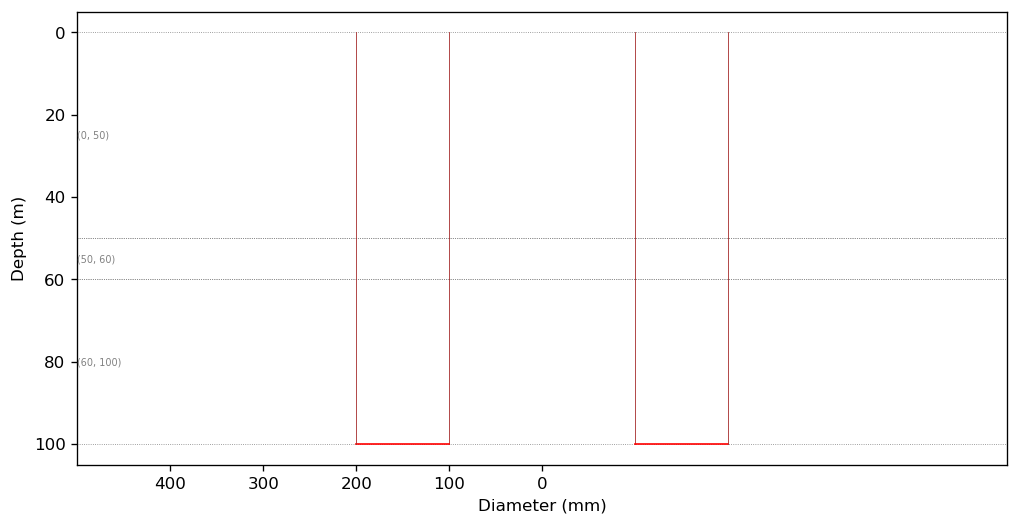

In [39]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
dh_cols = ["order_diam", "drilling_order", "from", "to", "diam"]

for ivl, sdf in subset_construction_by_intervals(df):
    logger.info(f"Depth interval: {ivl}")
    ax.axhline(ivl[0], ls=':', color='grey', lw=0.5)
    ax.axhline(ivl[1], ls=':', color='grey', lw=0.5)
    ax.text(500, ivl[1] - (ivl[1] - ivl[0]) / 2, str(ivl), fontsize='xx-small', color='grey', ha='left', va='center')
    
    dholes = sdf[sdf.type == "drilled_hole"].sort_values("order_diam")
    with pd.option_context("display.width", 1000):
        logger.info(f"Drilled hole sections in interval, ordered by diameter:\n{dholes}")
    for dh_idx, dhole in dholes.iterrows():
        later_dholes = df[df.drilling_order > dhole.drilling_order]
        later_max_dhole_diam = later_dholes.diam.max()
        logger.info(f"For drillhole {dh_idx}, later_max_dhole_diam={later_max_dhole_diam}")
        if ivl[1] == dhole.to:    
            ax.plot(
                [-1 * dhole.diam, -1 * later_max_dhole_diam],
                [ivl[1], ivl[1]],
                color="red",
                lw=1,
            )
            ax.plot(
                [dhole.diam, later_max_dhole_diam],
                [ivl[1], ivl[1]],
                color="red",
                lw=1,
            )
        ax.plot(
            [-1 * dhole.diam, -1 * dhole.diam], [ivl[0], ivl[1]], color="brown", lw=0.5
        )
        ax.plot([dhole.diam, dhole.diam], [ivl[0], ivl[1]], color="brown", lw=0.5)
        
        
    casings = sdf[sdf.type == "casing"].sort_values("order_diam")
    for cs_idx, casing in casings.iterrows():
        ax.plot(
            [-1 * casing.inner_diam, -1 * casing.inner_diam],
            [ivl[0], ivl[1]],
            color="black",
            lw=1,
        )
        ax.plot(
            [casing.inner_diam, casing.inner_diam],
            [ivl[0], ivl[1]],
            color="black",
            lw=1,
        )
    inner_casing_diam = casings.inner_diam.min()
        
    plugs = sdf[sdf.type == 'cement_plug']
    for plug_ix, plug in plugs.iterrows():
        earlier_dholes_than_plug = dholes[dholes.drilling_order <= plug.drilling_order]
        later_dholes_than_plug = dholes[dholes.drilling_order > plug.drilling_order]
        plug_outer_diam = min(casings.inner_diam.min(), earlier_dholes_than_plug.diam.min())
        plug_inner_diam = later_dholes_than_plug.diam.max()
        patch1 = mpatches.Rectangle((-1 * plug_outer_diam, ivl[0]), plug_outer_diam - plug_inner_diam, ivl[1] - ivl[0], facecolor='grey', alpha=0.25, lw=0)
        patch2 = mpatches.Rectangle((plug_inner_diam, ivl[0]), plug_outer_diam - plug_inner_diam, ivl[1] - ivl[0], facecolor='grey', alpha=0.25, lw=0)
        ax.add_artist(patch1)
        ax.add_artist(patch2)
    
    print()

ax.invert_yaxis()
ax.set_xticks(np.arange(0, 500, 100))
ax.set_xlim(500, -500)
ax.set_xlabel("Diameter (mm)")
ax.set_ylabel('Depth (m)')